# Project Name: Streaming Service Classifier (Web APIs & NLP Part 3)

## Content:
### 6. Modelling
### 7. Model Comparison
### 8. Conclusion
### 9. Recommendations
### 10. Further Improvements

### Import Libraries

In [1]:
#Import Libraries
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report,RocCurveDisplay, roc_auc_score

from IPython.display import display


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Load CSV data

In [2]:
reddit_df = pd.read_csv('reddit_df2.csv')

### Check First 5 Rows of the Dataset

In [3]:
reddit_df.head()

,subreddit,ups,upvote_ratio,num_comments,author,link_flair_text,awards,is_original_content,is_video,post_type,domain,created_utc,pinned,locked,stickied,alltext,topic,char_count,word_count,year_month,year_month_day,char_count_lem,word_count_lem
0,1,427,0.97,181,N3DSdude,Announcement,3,False,False,text,self.netflix,2021-04-24 15:24:04,False,False,True,r netflix discord server pleased announce affi...,Netflix,286,43,2021-04-01,2021-04-24,173,24
1,1,666,0.94,3059,UniversallySecluded,Megathread,0,False,False,text,self.netflix,2023-02-02 09:35:27,False,False,True,netflix announces plan crack password share me...,Netflix,1174,145,2023-02-01,2023-02-02,549,78
2,1,389,0.89,108,dailymail,NaN,0,False,False,link,dailymail.co.uk,2023-09-05 09:21:51,False,False,False,netflix live action adaptation one piece break...,Netflix,152,22,2023-09-01,2023-09-05,114,17
3,1,1048,0.92,218,Ben__Harlan,NaN,0,False,False,link,hardwaresfera.com,2023-09-04 12:17:51,False,False,False,aaron paul receive money break bad netflix,Netflix,66,12,2023-09-01,2023-09-04,42,7
4,1,6,0.80,6,Beau_bell,NaN,0,False,False,text,self.netflix,2023-09-05 13:21:10,False,False,False,stream show much downbeat unhappy general know...,Netflix,2014,355,2023-09-01,2023-09-05,1145,173


In [4]:
reddit_df = reddit_df[["subreddit", "alltext"]]

In [5]:
reddit_df.head()

,subreddit,alltext
0,1,r netflix discord server pleased announce affi...
1,1,netflix announces plan crack password share me...
2,1,netflix live action adaptation one piece break...
3,1,aaron paul receive money break bad netflix
4,1,stream show much downbeat unhappy general know...


In [6]:
reddit_df.isnull().sum()

subreddit    0
alltext      3
dtype: int64

In [7]:
reddit_df.dropna(subset=['alltext'], inplace=True)

In [8]:
reddit_df.shape

(6894, 2)

In [9]:
reddit_df['subreddit'].value_counts()

0    3644
1    3250
Name: subreddit, dtype: int64

In [10]:
reddit_df.isnull().sum()

subreddit    0
alltext      0
dtype: int64

In [11]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6894 entries, 0 to 6896
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  6894 non-null   int64 
 1   alltext    6894 non-null   object
dtypes: int64(1), object(1)
memory usage: 161.6+ KB


### Train Test Split
* 80% of the data will be trained
* 20% of the data will be tested

In [12]:
X = reddit_df["alltext"]
y = reddit_df["subreddit"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
reddit_df["subreddit"].value_counts(normalize = True)

0    0.528576
1    0.471424
Name: subreddit, dtype: float64

### Check Proportion of the Test Data
* 1 = Netflix
* 0 = Disneyplus

In [15]:
y_test.value_counts()

0    729
1    650
Name: subreddit, dtype: int64

With the current Test data obtained, there is a data imbalance of 5.72%, it is still within 10%.

### Function Creation for modelling: vector_model
The user defined function we execute the following:
* Define the pipeline
* Gridsearch CV
* Fitting Train Data
* Display GridSearch Results (Best Score, Train Score, Test Score, Best Estimators)
* Display Coefficient (If Applicable)
* Results of Different Metrics
* Classification Report
* ROC-AUC Score
* Confusion Matrix Plot
* ROC AUC Plot

In [16]:
# Function Creation for modelling

def vector_model(vector, vectorizer, model_name, model, pipe_params):
    start_time = time.time()
    # Define the pipeline first
    pipe = Pipeline([
        (vector, vectorizer),
        (model_name, model)
    ])
    
    
    # Define grid search
    gs = GridSearchCV(pipe,
                  param_grid = pipe_params,
                  cv = 5)
    
    
    # Do fitting
    gs.fit(X_train, y_train)
    
    
    # Display gridsearch result
    print(f"{model} Best Score: {gs.best_score_}")
    print(f"{model} Train Score: {gs.score(X_train, y_train)}")
    print(f"{model} Test Score: {gs.score(X_test, y_test)}")
    print(" ")
    print(f"{model} Best estimators: {gs.best_params_}")
    print(" ")
    print(" ")
    
    # The coef display
    if model_name == 'nb': 
        print("Useful words to differentiate the topics")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        log_prob_diff = gs.best_estimator_.steps[1][1].feature_log_prob_[1] - gs.best_estimator_.steps[1][1].feature_log_prob_[0]
        df_coef = pd.DataFrame(log_prob_diff, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
    
    elif model_name == 'lr':
        print("Useful words for Netflix")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.lr.coef_
        coef_val = np.exp(coef_val).T
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
        print("Useful words for Disneyplus")
        display(df_coef.sort_values(by = ['coef'], ascending = True).head(20))
        
    elif model_name == 'rf':
        print("Useful words to differentiate the topics")
        coef1 = gs.best_estimator_[0].get_feature_names_out()
        coef_val = gs.best_estimator_.named_steps.rf.feature_importances_
        df_coef = pd.DataFrame(coef_val, index=coef1)
        df_coef.columns = ["coef"]
        display(df_coef.sort_values(by = ['coef'], ascending = False).head(20))
        
    else:
        pass
    
    
    # The confusion matrix
    y_train_pred = gs.predict(X_train)
    y_test_pred = gs.predict(X_test)

    cm = confusion_matrix(y_test, y_test_pred)
    
    
   # Metric for Train data
    models = ["Specificity", "Accuracy", "Sensitivity / Recall", "Precision", "F1 Score"]
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    
    data_1 = [(tn / (tn+fp)),
              accuracy_score(y_train, y_train_pred),
              recall_score(y_train, y_train_pred),
              precision_score(y_train, y_train_pred),
              f1_score(y_train, y_train_pred)
             ]

    
    # Metric for Test data
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    
    data_2 = [(tn / (tn+fp)),
              accuracy_score(y_test, y_test_pred),
              recall_score(y_test, y_test_pred),
              precision_score(y_test, y_test_pred),
              f1_score(y_test, y_test_pred)
             ]
    
    
    # Create a dataframe to include the Metric for Train and Test
    cm_comparison = pd.DataFrame(data=data_1, 
                                 index=models,
                                 columns = ["Train"])
    
    cm_comparison["Test"] = data_2
    
    
    # Print Metric Results and Confusion Matrix
    print(" ")
    print("Model metrics")
    display(cm_comparison)
    
    print(" ")
    print(classification_report(y_test, y_test_pred))
    print(" ")
    
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    
    
    # plot roc curve
    print("ROC-AUC Train Score",roc_auc_score(y_train, gs.predict_proba(X_train)[:,1]))
    print("ROC-AUC Test Score",roc_auc_score(y_test, gs.predict_proba(X_test)[:,1]))
    print(" ")
    roc_display = RocCurveDisplay.from_estimator(gs, X_test,y_test)
    plt.plot([0,1],[0,1],label='baseline',linestyle='--')
    
    
    
    end_time = time.time()
    execution_time = end_time - start_time
    print("Script execution time: {:.2f} seconds".format(execution_time))

### Enhancing the list of stopwords from Count Vectorizer¶
The overlapped words will be removed so that we can do better analysis and modelling. This will also enhance the processing speed of the machine learning model.
<br/>
The words were taken from this notebook: project3_part2_data_clean_eda_lyw

In [17]:
# To get the base stopwords
stopwords_base = CountVectorizer(stop_words='english').get_stop_words()

#extrawords based on Count Vectorizer as count vectorizer looks at the count of words occurences literally
extra_words = ['watch',
              'like',
              'season',
              'movie',
              'make',
              'series',
              'episode',
              'good',
              'think',
              'know',
              'want',
              'time',
              'really',
              'new',
              'say',
              'way',
              'character',
              'look',
              'firm']

# Combine stopwords_base and extra_words
stopwords_enhanced = set(stopwords_base).union(extra_words)
stopwords_enhanced = list(stopwords_enhanced)

## 6. Modelling

A total of 8 models with CountVectorizer with Multinomial Naive Bayes as Baseline will be executed and identify the best model to classify.
<br>
<br>
**CountVectorizer with Multinomial Naive Bayes (Baseline)** is chosen as the baseline model as I want to see how well a model that does not take the context of a sentence when used with others words performs (Text data is never independent). Moreover, it is also a very fast modeling algorithm.
<br>
<br>
From here, other longer processing time models will also be included for comparisons
<br>
<br>
Various hyperparameters will also be included and the help of GridSearch CV will provide the best results based on the different combinations of hyperparameter values each model.




### Machine Learning Models


#### CountVectorizer

* Model 1 - CountVectorizer with Multinomial Naive Bayes (Baseline)
* Model 2 - CountVectorizer with KNNeighbours
* Model 3 - CountVectorizer with Logistic Regression
* Model 4 - CountVectorizer with Random Forest


#### TfidfVectorizer

* Model 5 - TfidfVectorizer with Multinomial Naive Bayes
* Model 6 - TfidfVectorizer with KNNeighbours
* Model 7 - TfidfVectorizer with Logistic Regression
* Model 8 - TfidfVectorizer with Random Forest

### Evaluation Metric
F1 Score will be used as the metric to evaluate the best performing model as it is crucial for the model to demostrate its effectiveness in distinguishing between the two classes (1 for Netflix and 0 for Disneyplus).

1. Minimising False Positives: A high F1 score means our model excels at correctly identifying text as belonging to Class 0 (Disneyplus) without mistakenly categorising it as Class 1 (Netflix) posts. This ensures that our model avoids making false positive predictions.

2. Minimising False Negatives: A high F1 score ensures that our models does not overlook relevant text belonging to Class 0 (Disneyplus). It effectively captures and classifies such text, avoiding false negatives.


### CountVectorizer

### CountVectorizer with Multinomial Naive Bayes (Baseline)

In [18]:
# CountVectorizer with Multinomial Naive Bayes (Baseline)

pipe_params_cv_nb = {
    'cvec__min_df':  [2, 3],
    'cvec__max_df': [ 0.9, 0.95],
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'nb__alpha': [0.1, 0.5, 1.0],
}

MultinomialNB() Best Score: 0.8979147778785131
MultinomialNB() Train Score: 0.927107887579329
MultinomialNB() Test Score: 0.9079042784626541
 
MultinomialNB() Best estimators: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.5}
 
 
Useful words to differentiate the topics


,coef
witcher,5.372457
marco,4.740270
squid,4.525159
reset,4.318544
saul,4.285208
ozark,4.215004
heist,4.014333
umbrella,4.014333
nudity,3.968871
bebop,3.921243


 
Model metrics


,Train,Test
Specificity,0.890223,0.876543
Accuracy,0.927108,0.907904
Sensitivity / Recall,0.968462,0.943077
Precision,0.887245,0.871977
F1 Score,0.926076,0.906135


 
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       729
           1       0.87      0.94      0.91       650

    accuracy                           0.91      1379
   macro avg       0.91      0.91      0.91      1379
weighted avg       0.91      0.91      0.91      1379

 
ROC-AUC Train Score 0.9820491489642432
ROC-AUC Test Score 0.9718391896169675
 
Script execution time: 216.46 seconds


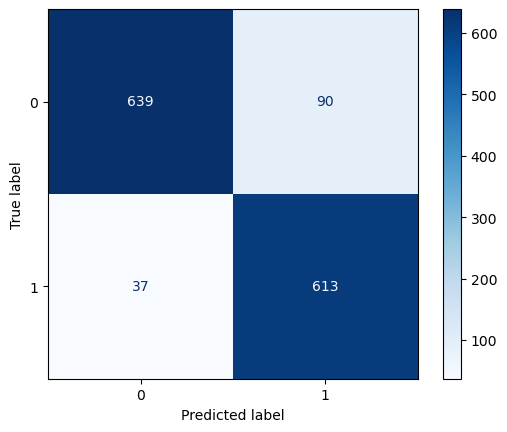

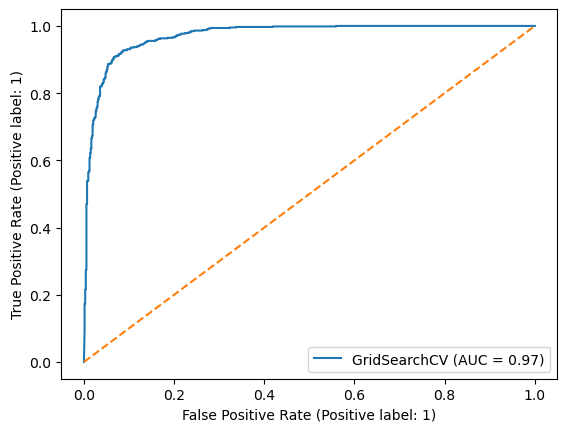

In [19]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'nb', MultinomialNB(), pipe_params_cv_nb)

Look at the useful words, some words that are generic such as reset, diet, umbrella and heist that can be helpful and easier for the marketing team to come out with marketing campaign to drift disneyplus subscribers to netflix as they are not words that are referring to shows very specifically. For e.g ozark, saul , airbender.
<br/>

What is surprising is that the the best performing n-gram is unigram as we saw that in the EDA, we get more context when there are two words involved and there is minimal overlapping words.
<br/>

The F1 score for test is able to meet the minimum criteria of 90% and it does not take too long for the script to finish executing.
<br/>

Although the model is overfitted, but it remains our threshold of 10%
<br/>

The ROC AUC score is close to 1, implying that this model is good at distinguishing between Netflix and Disneyplus topics as higher true positive rate and a lower false positive rate indicates a better balance between sensitivity and specificity.

### CountVectorizer with KNNeighbours

In [20]:
# CountVectorizer with KNNeighbours

pipe_params_cv_knn = {
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'knn__n_neighbors':  list(range(1,51,10)),
    'knn__metric': ['euclidean','manhattan']
}

KNeighborsClassifier() Best Score: 0.8643699002719855
KNeighborsClassifier() Train Score: 0.9967361740707162
KNeighborsClassifier() Test Score: 0.8593183466279913
 
KNeighborsClassifier() Best estimators: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'knn__metric': 'manhattan', 'knn__n_neighbors': 1}
 
 
 
Model metrics


,Train,Test
Specificity,0.999314,0.950617
Accuracy,0.996736,0.859318
Sensitivity / Recall,0.993846,0.756923
Precision,0.999227,0.931818
F1 Score,0.996529,0.835314


 
              precision    recall  f1-score   support

           0       0.81      0.95      0.88       729
           1       0.93      0.76      0.84       650

    accuracy                           0.86      1379
   macro avg       0.87      0.85      0.86      1379
weighted avg       0.87      0.86      0.86      1379

 
ROC-AUC Train Score 0.9965800237498351
ROC-AUC Test Score 0.853770180436847
 
Script execution time: 1166.52 seconds


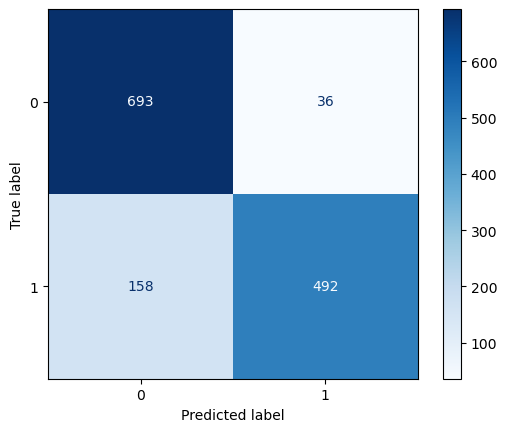

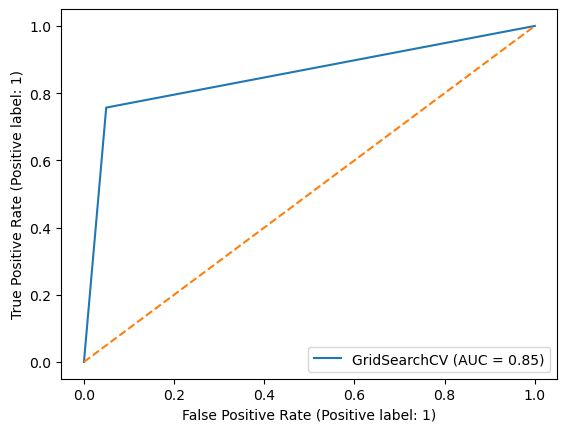

In [21]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'knn', KNeighborsClassifier(), pipe_params_cv_knn)

This model performs worse than our baseline and also overfits over our threshold of 10%. Thus, no point to consider it as a potential model for classifying the two subreddit topics. Furthermore, it has very long processing time.

### CountVectorizer with Logistic Regression

In [22]:
# CountVectorizer with Logistic Regression

pipe_params_cv_lr = {
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95], 
    'cvec__max_features': [2000, 3000, 4000, 5000], 
    'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.1, 1.0, 10.0],
}

LogisticRegression(solver='liblinear') Best Score: 0.9269265639165912
LogisticRegression(solver='liblinear') Train Score: 0.9883952855847689
LogisticRegression(solver='liblinear') Test Score: 0.9238578680203046
 
LogisticRegression(solver='liblinear') Best estimators: {'cvec__max_df': 0.9, 'cvec__max_features': 5000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'lr__C': 1.0, 'lr__penalty': 'l2'}
 
 
Useful words for Netflix


,coef
netflix,93.594046
witcher,11.111155
ozark,4.379139
stranger thing,3.941668
stranger,3.400938
irishman,3.302895
wednesday,3.206270
chef,3.194090
piece,3.183686
strange thing,3.019145


Useful words for Disneyplus


,coef
disney,0.014452
disneyplus,0.086647
mandalorian,0.150867
marvel,0.170964
wandavision,0.206906
loki,0.239307
poster,0.249213
andor,0.273961
hulk,0.279432
star original,0.295450


 
Model metrics


,Train,Test
Specificity,0.997256,0.958848
Accuracy,0.988395,0.923858
Sensitivity / Recall,0.978462,0.884615
Precision,0.996865,0.950413
F1 Score,0.987578,0.916335


 
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       729
           1       0.95      0.88      0.92       650

    accuracy                           0.92      1379
   macro avg       0.93      0.92      0.92      1379
weighted avg       0.93      0.92      0.92      1379

 
ROC-AUC Train Score 0.9990812112415886
ROC-AUC Test Score 0.9843315395167246
 
Script execution time: 436.52 seconds


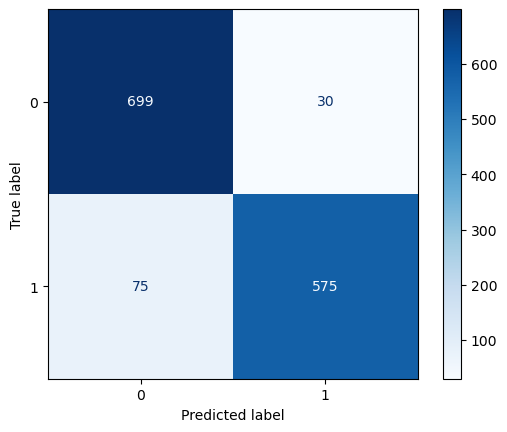

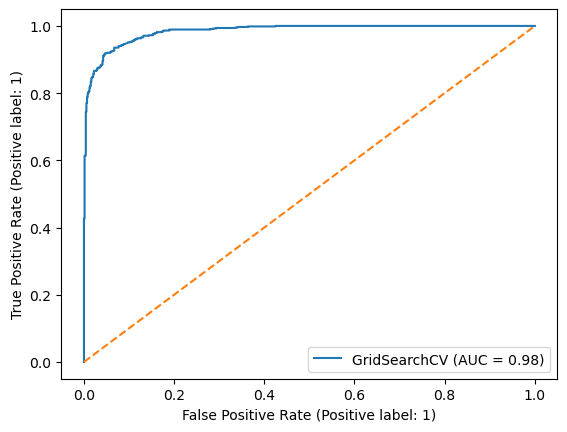

In [23]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'lr', LogisticRegression(solver='liblinear'), pipe_params_cv_lr)

CountVectorizer with Logistic Regression performs better than the baseline model even though it overfits more. But it is still acceptable as it remains our threshold of 10%.
<br/>

Keywords that are valuable for classifying content related to Netflix include Witcher, Ozark, Stranger Things, Stranger, and Irishman.
<br/>

Keywords that are valuable for classifying content related to Disneyplus include mandalorian, marvel, wandavision,loki, hulk.
<br/>

The Netflix marketing can also use some of the generic words such as poster, superhero , frozen (although it is a show name) to make up words for marketing campaign or content creation, drifting disneyplus subscribers to netflix.
<br/>

The F1 score for test is able to meet the minimum criteria of 90% and it does not take too long for the script to finish executing.
<br/>


The ROC AUC score is close to 1, implying that this model is good at distinguishing between Netflix and Disneyplus topics as higher true positive rate and a lower false positive rate indicates a better balance between sensitivity and specificity.

### CountVectorizer with Random Forest

In [24]:
# CountVectorizer with Random Forest

pipe_params_cv_rf = {
    'cvec__min_df': [2, 3],
    'cvec__max_df': [0.9, 0.95],
    'cvec__max_features': [2000, 3000, 4000,5000],
    'cvec__ngram_range':  [(1, 1), (1, 2), (2, 2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [5, 10, 15]
}

RandomForestClassifier() Best Score: 0.9008159564823209
RandomForestClassifier() Train Score: 0.9178603807796918
RandomForestClassifier() Test Score: 0.889050036258158
 
RandomForestClassifier() Best estimators: {'cvec__max_df': 0.95, 'cvec__max_features': 5000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 2), 'rf__max_depth': 15, 'rf__n_estimators': 100}
 
 
Useful words to differentiate the topics


,coef
netflix,0.150362
disney,0.129594
disney plus,0.033952
plus,0.023257
star,0.021973
marvel,0.018736
war,0.015273
star war,0.011504
thing,0.010106
mandalorian,0.009707


 
Model metrics


,Train,Test
Specificity,0.972556,0.951989
Accuracy,0.917860,0.889050
Sensitivity / Recall,0.856538,0.818462
Precision,0.965323,0.938272
F1 Score,0.907683,0.874281


 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       729
           1       0.94      0.82      0.87       650

    accuracy                           0.89      1379
   macro avg       0.90      0.89      0.89      1379
weighted avg       0.89      0.89      0.89      1379

 
ROC-AUC Train Score 0.9843559176672385
ROC-AUC Test Score 0.9700179381660863
 
Script execution time: 1551.06 seconds


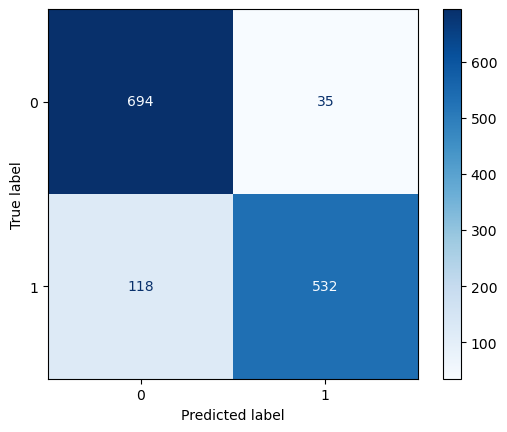

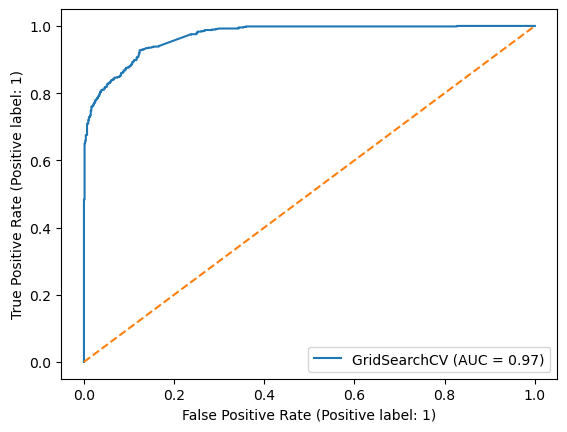

In [25]:
vector_model('cvec', CountVectorizer(stop_words = stopwords_enhanced), 'rf', RandomForestClassifier(), pipe_params_cv_rf)

The F1 score for test did not meet the minimum criteria of 90% and it does not take too long for the script to finish executing.
<br/>

Furthermore, it has the longest processing time.

### TfidfVectorizer

### TfidfVectorizer with Multinomial Naive Bayes

In [26]:
# TfidfVectorizer with Multinomial Naive Bayes

pipe_params_tvec_nb = {
    'tvec__min_df':  [2, 3],
    'tvec__max_df': [ 0.9, 0.95],
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__ngram_range':[(1, 1), (1, 2), (2, 2)],
    'nb__alpha': [0.1, 0.5, 1.0],
}

MultinomialNB() Best Score: 0.9062556663644605
MultinomialNB() Train Score: 0.9437896645512239
MultinomialNB() Test Score: 0.911530094271211
 
MultinomialNB() Best estimators: {'nb__alpha': 1.0, 'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2)}
 
 
Useful words to differentiate the topics


,coef
witcher,3.365770
netflix,3.087333
stranger thing,2.956298
trailer netflix,2.691298
stranger,2.676329
netflix original,2.614100
netflix cancel,2.398684
renew netflix,2.378071
cancel netflix,2.243504
black mirror,2.238310


 
Model metrics


,Train,Test
Specificity,0.926587,0.887517
Accuracy,0.943790,0.911530
Sensitivity / Recall,0.963077,0.938462
Precision,0.921266,0.881503
F1 Score,0.941707,0.909091


 
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       729
           1       0.88      0.94      0.91       650

    accuracy                           0.91      1379
   macro avg       0.91      0.91      0.91      1379
weighted avg       0.91      0.91      0.91      1379

 
ROC-AUC Train Score 0.9896138012930465
ROC-AUC Test Score 0.9774643874643876
 
Script execution time: 202.83 seconds


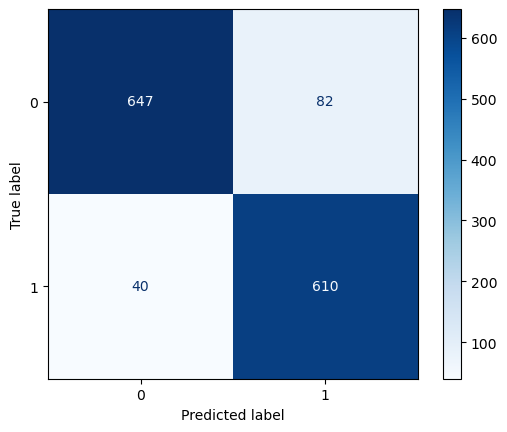

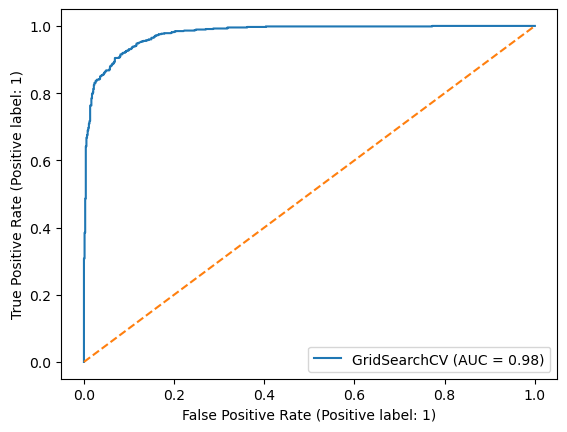

In [27]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'nb', MultinomialNB(), pipe_params_tvec_nb)

TfidfVectorizer with Multinomial Naive Bayes performs better than the baseline model even though it overfits more. But it is still acceptable as it remains our threshold of 10%.
<br/>

The F1 score for test is able to meet the minimum criteria of 90% and it does not take too long for the script to finish executing.
<br/>


Using TFID Vectorizer with Naive Bayes model, the top 5 useful words in classifying the topics are witcher, netflix, stranger thing, trailer netflix and stranger.

The Netflix marketing can also use some of the generic words such as squid, mirror , stranger (although they are referring to the show name) for their campaign.
<br/>

The ROC AUC score is close to 1, implying that this model is good at distinguishing between Netflix and Disneyplus topics as higher true positive rate and a lower false positive rate indicates a better balance between sensitivity and specificity.


### TfidfVectorizer with KNNeighbours

In [28]:
# TfidfVectorizer with KNNeighbours

pipe_params_tvec_knn = {
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.9, 0.95],
    'tvec__max_features': [2000, 3000, 4000, 5000],
    'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'knn__n_neighbors':  list(range(1,51,10)),
    'knn__metric': ['euclidean','manhattan']
}

KNeighborsClassifier() Best Score: 0.7724388032638259
KNeighborsClassifier() Train Score: 0.8750679963735267
KNeighborsClassifier() Test Score: 0.7657722987672226
 
KNeighborsClassifier() Best estimators: {'knn__metric': 'euclidean', 'knn__n_neighbors': 1, 'tvec__max_df': 0.9, 'tvec__max_features': 2000, 'tvec__min_df': 2, 'tvec__ngram_range': (2, 2)}
 
 
 
Model metrics


,Train,Test
Specificity,0.989708,0.945130
Accuracy,0.875068,0.765772
Sensitivity / Recall,0.746538,0.564615
Precision,0.984779,0.901720
F1 Score,0.849267,0.694418


 
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       729
           1       0.90      0.56      0.69       650

    accuracy                           0.77      1379
   macro avg       0.81      0.75      0.75      1379
weighted avg       0.80      0.77      0.76      1379

 
ROC-AUC Train Score 0.8681234331706029
ROC-AUC Test Score 0.7548728500580353
 
Script execution time: 1605.14 seconds


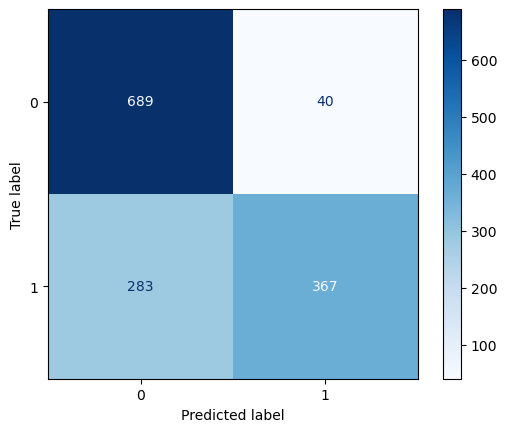

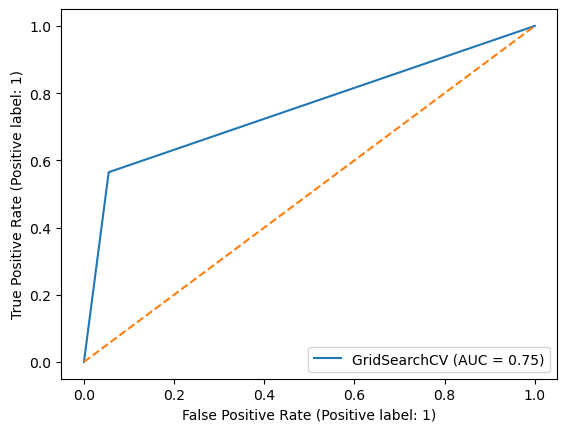

In [29]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'knn', KNeighborsClassifier(), pipe_params_tvec_knn)

This model performs the worst and also overfits over our threshold of 10%. Thus, no point to consider it as a potential model for classifying the two subreddit topics. Furthermore, it has very long processing time.

### TfidfVectorizer with Logistic Regression

In [30]:
# TfidfVectorizer with Logistic Regression

pipe_params_tvec_lr = {
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.9, 0.95], 
    'tvec__max_features': [2000, 3000, 4000, 5000], 
    'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.1, 1.0, 10.0],
}

C:\Users\Lua Yeow Wen\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(solver='liblinear') Best Score: 0.9338168631006347
LogisticRegression(solver='liblinear') Train Score: 0.9931097008159565
LogisticRegression(solver='liblinear') Test Score: 0.9354604786076868
 
LogisticRegression(solver='liblinear') Best estimators: {'lr__C': 10.0, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 2)}
 
 
Useful words for Netflix


,coef
netflix,9.024050e+10
witcher,6.526198e+02
ozark,8.066328e+01
people,6.074088e+01
chef,4.889610e+01
game,4.861201e+01
saul,4.234051e+01
piece,3.965275e+01
stranger thing,3.760247e+01
hulu espn,3.528769e+01


Useful words for Disneyplus


,coef
disney,5.532268e-11
disneyplus,8.255046e-04
mandalorian,3.428992e-03
marvel,3.571363e-03
wandavision,8.609569e-03
hulk,1.225461e-02
andor,1.543175e-02
loki,1.828512e-02
star original,1.969625e-02
spider man,2.054666e-02


 
Model metrics


,Train,Test
Specificity,0.996226,0.945130
Accuracy,0.993110,0.935460
Sensitivity / Recall,0.989615,0.924615
Precision,0.995743,0.937598
F1 Score,0.992670,0.931061


 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       729
           1       0.94      0.92      0.93       650

    accuracy                           0.94      1379
   macro avg       0.94      0.93      0.94      1379
weighted avg       0.94      0.94      0.94      1379

 
ROC-AUC Train Score 0.9991780577912653
ROC-AUC Test Score 0.9842998839295135
 
Script execution time: 422.32 seconds


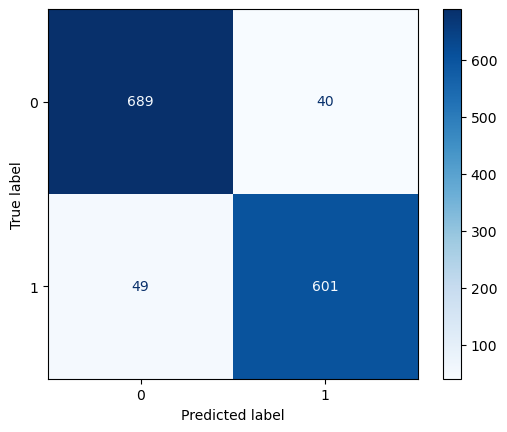

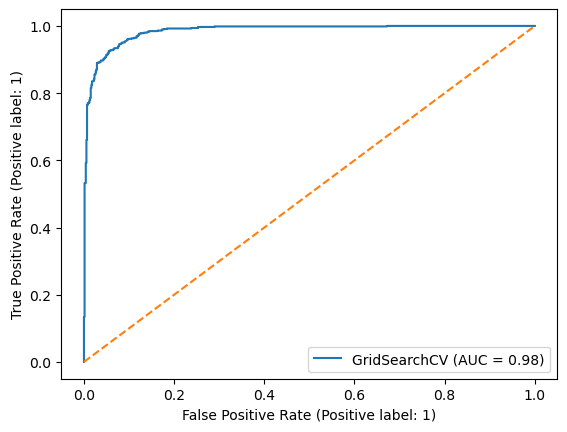

In [31]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'lr', LogisticRegression(solver='liblinear'), pipe_params_tvec_lr)

TfidfVectorizer with Logistic Regression performs better than the baseline model even though it overfits more. But it is still acceptable as it remains our threshold of 10%.
<br/>

Keywords that are valuable for classifying content related to Netflix include Witcher, Ozark, saul, stranger thing, and irishman.
<br/>

Keywords that are valuable for classifying content related to Disneyplus include mandalorian, marvel, wandavision,loki, hulk.
<br/>

The Netflix marketing can also use some of the generic words such as poster, tangle, entry, born and frozen (although it is a show name) to make up words for marketing campaign or content creation, drifting disneyplus subscribers to netflix.
<br/>

The F1 score for test is able to meet the minimum criteria of 90% and it does not take too long for the script to finish executing.
<br/>


The ROC AUC score is close to 1, implying that this model is good at distinguishing between Netflix and Disneyplus topics as higher true positive rate and a lower false positive rate indicates a better balance between sensitivity and specificity.

### TfidfVectorizer with Random Forest

In [32]:
# TfidfVectorizer with Random Forest

pipe_params_tvec_rf = {
    'tvec__min_df': [2, 3],
    'tvec__max_df': [0.9, 0.95],
    'tvec__max_features': [2000, 3000, 4000,5000],
    'tvec__ngram_range':  [(1, 1), (1, 2), (2, 2)],
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [5, 10, 15]
}

RandomForestClassifier() Best Score: 0.9022665457842249
RandomForestClassifier() Train Score: 0.928014505893019
RandomForestClassifier() Test Score: 0.8970268310369833
 
RandomForestClassifier() Best estimators: {'rf__max_depth': 15, 'rf__n_estimators': 150, 'tvec__max_df': 0.95, 'tvec__max_features': 3000, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}
 
 
Useful words to differentiate the topics


,coef
disney,0.135689
netflix,0.121414
plus,0.028686
marvel,0.027286
star,0.025679
war,0.017671
witcher,0.014123
thing,0.013041
game,0.012816
stop,0.010195


 
Model metrics


,Train,Test
Specificity,0.982161,0.960219
Accuracy,0.928015,0.897027
Sensitivity / Recall,0.867308,0.826154
Precision,0.977460,0.948763
F1 Score,0.919095,0.883224


 
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       729
           1       0.95      0.83      0.88       650

    accuracy                           0.90      1379
   macro avg       0.90      0.89      0.90      1379
weighted avg       0.90      0.90      0.90      1379

 
ROC-AUC Train Score 0.9874744689272992
ROC-AUC Test Score 0.9730463226759524
 
Script execution time: 1700.12 seconds


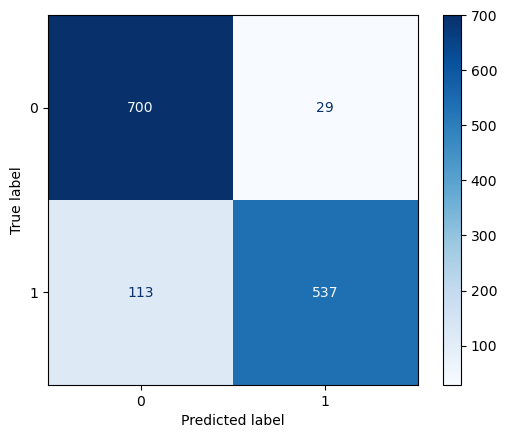

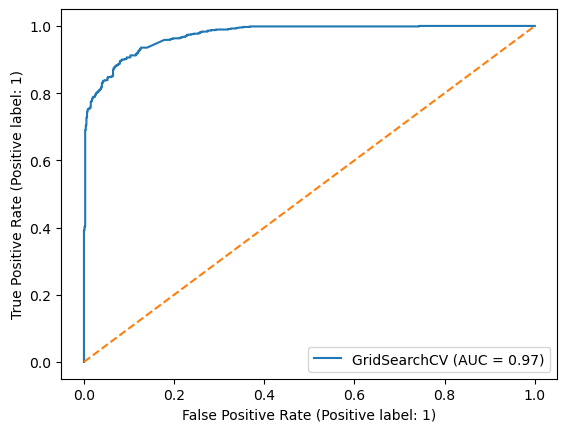

In [33]:
vector_model('tvec', TfidfVectorizer(stop_words = stopwords_enhanced), 'rf', RandomForestClassifier(), pipe_params_tvec_rf)

### Model 8 - TfidfVectorizer with Random Forest

The F1 score for test did not meet the minimum criteria of 90% and it does not take too long for the script to finish executing.
<br/>

Furthermore, it has the longest processing time.

## 7. Model Comparison

| **Vectorizer** | **Model**      | **Best Score** | **Train Score** | **Test Score** | **Train Accuracy** | **Test Accuracy** | **Train F1 Score** | **Test F1 Score** | **Train ROC-AUC** | **Test ROC-AUC** | **Execution Time  (Seconds)** | **Remark** |
|----------------|----------------|----------------|-----------------|----------------|--------------------|-------------------|--------------------|-------------------|-------------------|------------------|-------------------------------|------------|
| CVEC           | Multinomial NB | 0.898          | 0.927           | 0.908          | 0.927              | 0.908             | 0.926              | 0.906             | 0.982             | 0.972            | 263.7                         | Baseline   |
| CVEC           | KNN            | 0.864          | 0.997           | 0.859          | 0.997              | 0.859             | 0.997              | 0.835             | 0.997             | 0.854            | 1414.31                       | -          |
| CVEC           | Log Reg        | 0.927          | 0.988           | 0.924          | 0.988              | 0.924             | 0.988              | 0.916             | 0.999             | 0.984            | 551.23                        | -          |
| CVEC           | Random Forest  | 0.900          | 0.913           | 0.888          | 0.913              | 0.888             | 0.900              | 0.870             | 0.984             | 0.971            | 1873.82                       | -          |
| TVEC           | Multinomial NB | 0.906          | 0.944           | 0.912          | 0.944              | 0.912             | 0.942              | 0.909             | 0.990             | 0.977            | 253.96                        | -          |
| TVEC           | KNN            | 0.772          | 0.875           | 0.766          | 0.875              | 0.766             | 0.849              | 0.694             | 0.868             | 0.755            | 1823.63                       | -          |
| **TVEC**       | **Log Reg**    | 0.934          | **0.993**       | 0.935          | 0.993              | **0.935**         | 0.993              | **0.931**         | 0.999             | **0.984**        | 592.46                        | -          |
| TVEC           | Random Forest  | 0.903          | 0.921           | 0.887          | 0.921              | 0.887             | 0.909              | 0.871             | 0.986             | 0.969            | 1996.41                       | -          |

Observations from the table above:

Amongst all the model, CountVectorizer and TfidfVectorizer with both KNNeighbours and Random Forest did not perform well in our metric (F1 Score). They also consume the most processing time. 
<br/>

Even though all the models are overfitted due to data imbalance, Multinomial Naive Bayes and Logistic Regression are still able to meet the threshold of 10%.
<br/>

TfidfVectorizer with Logistic Regression attained the best F1 Score of 0.931 with execution time of 592.46s.
It is one of the fastest running model which is crucial as there will be more data to be train and tested which will lead to longer processing time.
<br/>

TfidfVectorizer with Logistic Regression also performs well with the mixed of unigrams and bigrams.

The ROC AUC score is close to 1, implying that this model is good at distinguishing between Netflix and Disneyplus topics as higher true positive rate and a lower false positive rate indicates a better balance between sensitivity and specificity.

## 8. Conclusion

Based on the finding in model comparison, we will propose our TfidfVectorizer with Logistic Regression model to our stakeholders (Netflix marketing team).

The model is able to distinguishing between Netflix and Disneyplus topics so thatthe words that are purposely picked from Disneyplus for Netflix marketing campaign will stand higher chance for their posts to be seen by Disneyplus subscribers on reddit as they key in the words in the search engine.

With short processing time, we can constantly provide different keywords to our stakeholders with a short turnaround time. This is so that the marketing team can quickly have the content team to work on newer contents with words that are impactful in the show names.


Keywords that are valuable for classifying content related to Disneyplus include mandalorian, marvel, wandavision,loki, hulk can also help the Netflix team to understand the content that Disneyplus prefer and create shows that with similar genres.

The Netflix marketing can also use some of the generic words such as poster, tangle, entry, born and frozen (although it is a show name) to make up words for marketing campaign or content creation, drifting disneyplus subscribers to netflix.

However, there are some limitations with our model such as:
* The content and associated keywords for both platforms are constantly evolving.
* Using Disneyplus keywords on Netflix and retraining the model may blur semantic distinctions between the two platforms over time.
* Text classification models can identify keywords but might struggle with understanding context or sentiment.

## 9. Reccomendations

* Leverage on Popular Disney Themes: 
Develop content in trending genres like sci-fi and superheroes to cater to DisneyPlus fans seeking variety.

* Enhance User Experience: 
Prioritize platform usability and innovative features to outshine competitors and retain customers.

* Content Marketing: 
Spotlight unique Netflix content to position the platform as either a complement or superior alternative to DisneyPlus.

## 10. Further Improvements

* Data Expansion: Collect more data over time to improve the model's robustness
* Data Imbalance: Implement algorithm such as SMOTE to handle increasing data imbalance over time.
* Sentiment Analysis: Incorporate sentiment scores as features to understand the sentiment behind each text.
* Model Exploration: Try more advanced models like deep learning for text classification.
* Ensemble Methods: Combine predictions from multiple models to improve metrics.